In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import tqdm.notebook as tqdm

from pathlib import Path

%matplotlib inline


import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, GlobalMaxPooling2D

In [2]:
DATA_DIR_PATH = "../data/bengali_AI_handwritten_grapheme_classification"

IMG_HEIGHT = 137
IMG_WIDTH = 236

ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [3]:
original_train_df = pd.read_csv("{}/train.csv".format(DATA_DIR_PATH))
test_df = pd.read_csv("{}/test.csv".format(DATA_DIR_PATH))
class_map_df = pd.read_csv("{}/class_map.csv".format(DATA_DIR_PATH))
sample_submission_df = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR_PATH))

In [4]:
def reshape_img(img_data):
    if isinstance(img_data, pd.Series):
        img_data = img_data.to_numpy()
    
    return img_data.reshape(IMG_HEIGHT, IMG_WIDTH)

In [5]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [6]:
class_map_df

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [7]:
original_train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [8]:
CENTERED_IMAGE_PATH = "../data/bengali_centered"
PREPROCESSED_TRIAN_DATA_CSV_NAME = "new_train_data.csv"

In [9]:
def update_df_with_image_path(df: pd.DataFrame, dataset_name_list: list):
    image_path_list = list()

    for dataset_name in dataset_name_list:
        image_path_data_list = list()
        centered_image_dataset_path = os.path.join(CENTERED_IMAGE_PATH, dataset_name)

        for file in sorted(os.listdir(centered_image_dataset_path)):
            image_id, ext = os.path.splitext(file)

            if ext != ".jpg":
                continue

            idx = int(image_id.split("_")[-1])
            path_data = (idx, image_id, os.path.join(centered_image_dataset_path, file))

            image_path_data_list.append(path_data)

        image_path_data_list = sorted(image_path_data_list, key=lambda path_data: path_data[0])
        image_path_list_in_dataset = list(list(zip(*image_path_data_list))[2])
        image_path_list += image_path_list_in_dataset

    df['preprocessed_image_path'] = image_path_list
    df['filename'] = df['image_id'].map(lambda x: x + ".jpg")

In [10]:
# update_df_with_image_path(df=original_train_df, dataset_name_list=["dataset_1", "dataset_2", "dataset_3", "dataset_4"])
# original_train_df.to_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME), mode='w', index=False)

preprocessed_train_df = pd.read_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME))

In [11]:
preprocessed_train_df.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path,filename
200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...,Train_200835.jpg
200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...,Train_200836.jpg
200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...,Train_200837.jpg
200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...,Train_200838.jpg
200839,Train_200839,127,2,0,ল্টি,../data/bengali_centered/dataset_4/Train_20083...,Train_200839.jpg


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# class BengaliImageDataGenerator(ImageDataGenerator):
    
#     def __init__(self,
#                  featurewise_center=False,
#                    samplewise_center=False,
#                    featurewise_std_normalization=False,
#                    samplewise_std_normalization=False,
#                    zca_whitening=False,
#                    zca_epsilon=1e-6,
#                    rotation_range=0,
#                    width_shift_range=0.,
#                    height_shift_range=0.,
#                    brightness_range=None,
#                    shear_range=0.,
#                    zoom_range=0.,
#                    channel_shift_range=0.,
#                    fill_mode='nearest',
#                    cval=0.,
#                    horizontal_flip=False,
#                    vertical_flip=False,
#                    rescale=None,
#                    preprocessing_function=None,
#                    data_format=None,
#                    validation_split=0.0,
#                    dtype=None):
#         super(BengaliImageDataGenerator, self).__init__(
#                  featurewise_center=featurewise_center,
#                    samplewise_center=samplewise_center,
#                    featurewise_std_normalization=featurewise_std_normalization,
#                    samplewise_std_normalization=samplewise_std_normalization,
#                    zca_whitening=zca_whitening,
#                    zca_epsilon=zca_epsilon,
#                    rotation_range=rotation_range,
#                    width_shift_range=width_shift_range,
#                    height_shift_range=height_shift_range,
#                    brightness_range=brightness_range,
#                    shear_range=shear_range,
#                    zoom_range=zoom_range,
#                    channel_shift_range=channel_shift_range,
#                    fill_mode=fill_mode,
#                    cval=cval,
#                    horizontal_flip=horizontal_flip,
#                    vertical_flip=vertical_flip,
#                    rescale=rescale,
#                    preprocessing_function=preprocessing_function,
#                    data_format=data_format,
#                    validation_split=validation_split,
#                    dtype=dtype)
        
#     def flow_from_dataframe(self,
#                             dataframe,
#                             directory=None,
#                             x_col="filename",
#                             y_col="class",
#                             weight_col=None,
#                             target_size=(256, 256),
#                             color_mode='rgb',
#                             classes=None,
#                             class_mode='categorical',
#                             batch_size=32,
#                             shuffle=True,
#                             seed=None,
#                             save_to_dir=None,
#                             save_prefix='',
#                             save_format='png',
#                             subset=None,
#                             interpolation='nearest',
#                             validate_filenames=True,
#                             **kwargs):
#         for img_batch, label_batch in super(BengaliImageDataGenerator, self).flow_from_dataframe(
#                             dataframe=dataframe,
#                             directory=directory,
#                             x_col=x_col,
#                             y_col=y_col,
#                             weight_col=weight_col,
#                             target_size=target_size,
#                             color_mode=color_mode,
#                             classes=classes,
#                             class_mode=class_mode,
#                             batch_size=batch_size,
#                             shuffle=shuffle,
#                             seed=seed,
#                             save_to_dir=save_to_dir,
#                             save_prefix=save_prefix,
#                             save_format=save_format,
#                             subset=subset,
#                             interpolation=interpolation,
#                             validate_filenames=validate_filenames,
#                             **kwargs):
#             yield img_batch, label_batach
        
# #         new_data_batch_list = list()
# #         print(len(data_batch_list))
        
# #         for data_batch in tqdm.tqdm(data_batch_list):
# #             new_data_batch = list()
# #             new_img_batch = list()
# #             new_root_label_batch = list()
# #             new_vowel_label_batch = list()
# #             new_consonant_label_batch =list()
            
# #             for img_batch, label_batch in zip(data_batch[0], data_batch[1]):
# #                 img = img_batch
# #                 root_label, vowel_label, consonant_label = label_batch
                
# #                 new_img_batch.append(img)
# #                 new_root_label_batch.append(root_label)
# #                 new_vowel_label_batch.append(vowel_label)
# #                 new_consonant_label_batch.append(consonant_label)
            
# #             new_data_batch.append(new_img_batch)
# #             new_data_batch.append(new_root_label_batch)
# #             new_data_batch.append(new_vowel_label_batch)
# #             new_data_batch.append(new_consonant_label_batch)
            
# #             new_data_batch_list.append(new_data_batch)
            
# #         yield new_data_batch_list

In [14]:
# new_data_gen = BengaliImageDataGenerator(rescale=1./255, rotation_range=20)

In [15]:
# new_train_dataset1_generator = new_data_gen.flow_from_dataframe(
#     dataframe=preprocessed_train_df[:5000],
#     directory=os.path.join(CENTERED_IMAGE_PATH, "dataset_1"),
#     x_col="filename",
#     y_col=["grapheme_root", "vowel_diacritic", "consonant_diacritic"],
#     batch_size=32,
#     seed=42,
#     shuffle=True,
#     class_mode="other",
#     target_size=(64, 64)
# )

In [16]:
# new_train_dataset1_generator.next()

In [17]:
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20)

In [18]:
train_dataset1_generator = data_gen.flow_from_dataframe(
    dataframe=preprocessed_train_df,
    directory=os.path.join(CENTERED_IMAGE_PATH, "dataset_1"),
    x_col="filename",
    y_col=["grapheme_root", "vowel_diacritic", "consonant_diacritic"],
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(64, 64)
)

Found 50210 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 150630 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [19]:
def create_data_generator(generator):
    while True:
        img_batch, label_batch = generator.next()
        
        bengali_label_dict = dict()
        
        bengali_label_dict['root'] = list()
        bengali_label_dict['consonant'] = list()
        bengali_label_dict['vowel'] = list()
        
        for label_list in label_batch:        
            root_label, vowel_label, consonant_label = label_list
            
            bengali_label_dict['root'].append([root_label])
            bengali_label_dict['consonant'].append([vowel_label])
            bengali_label_dict['vowel'].append([consonant_label])
            
        bengali_label_dict['root'] = np.asarray(bengali_label_dict['root'])
        bengali_label_dict['consonant'] = np.asarray(bengali_label_dict['consonant'])
        bengali_label_dict['vowel'] = np.asarray(bengali_label_dict['vowel'])

        yield {'img': img_batch}, bengali_label_dict

In [20]:
data_generator = create_data_generator(train_dataset1_generator)

In [21]:
import efficientnet.tfkeras as efn

In [22]:
# base_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_net.trainable = False

In [23]:
# del model

In [24]:
# inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='img')
inputs = Input(shape=(64, 64, 3), name='img')

# m = Conv2D(3, (3, 3), padding='same',  kernel_initializer='he_uniform', bias_initializer='zeros')(inputs)
m = base_net(inputs)
m = GlobalMaxPooling2D()(m)


# m = Conv2D(32, 3, padding='same', activation='relu')(inputs)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(64, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(128, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(256, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)


# m = Conv2D(512, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Flatten()(m)
# m = Dropout(rate=0.2)(m)

# m = Dense(256, activation='relu')(m)
m = Dropout(rate=0.4)(m)
m = Dense(128, activation='relu')(m)
m = Dropout(rate=0.4)(m)

root = Dense(ROOT_CLASSES_NUM, activation='softmax', name='root')(m)
consonant = Dense(CONSONANT_CLASSES_NUM, activation='softmax', name='consonant')(m)
vowel = Dense(VOWEL_CLASSES_NUM, activation='softmax', name='vowel')(m)

In [25]:
# model = tf.keras.Model(inputs=inputs, outputs=[root])
model = tf.keras.Model(inputs=inputs, outputs=[root, consonant, vowel])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
efficientnet-b0 (Model)         (None, 2, 2, 1280)   4049564     img[0][0]                        
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1280)         0           efficientnet-b0[1][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           global_max_pooling2d[0][0]       
______________________________________________________________________________________________

In [27]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Nadam, SGD
import tensorflow

In [28]:
model.compile(
    optimizer='adam',
    loss={'root': 'categorical_crossentropy', 'consonant': 'categorical_crossentropy', 'vowel': 'categorical_crossentropy'},
    metrics={'root': 'accuracy', 'consonant': 'accuracy', 'vowel': 'accuracy'}
)

In [29]:
model.fit_generator(
    generator=data_generator,
    epochs=5
)

Instructions for updating:
Please use Model.fit, which supports generators.
  {'root': '...', 'consonant': '...', 'vowel': '...'}
    to  
  ['...', '...', '...']
Epoch 1/5
1228026/Unknown - 53897s 44ms/step - loss: 5841081050.0890 - root_loss: 5840711168.0000 - consonant_loss: 275899.1875 - vowel_loss: 18963.3613 - root_accuracy: 0.0136 - consonant_accuracy: 0.3934 - vowel_accuracy: 0.4108

KeyboardInterrupt: 

In [38]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [64, 64])

    return img

def load_img(path_list):
    return tf.map_fn(read_img, path_list, dtype=tf.float32)

In [39]:
history_list = list()

for epoch in range(50):
    
    print("== Epoch : {} ==\n".format(epoch))
    dataset = dataset.shuffle(len(path_list))
    
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(25600):
#     for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.take(2):
        time_st = time.time()
        img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
        time_ed = time.time()
        print("Elapsed time for loading image data : {}".format(time_ed - time_st))
        
        history = model.fit(
            x={'img': img_batch},
#             y={'root': root_batch},
            y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
            batch_size=256  # 64, 128, 256 은 GPU 메모리 부족
        )
        
        # Appending history
        history_list.append((epoch, history))
    
    print(f"Epoch {epoch} - ")

== Epoch : 0 ==

Elapsed time for loading image data : 25.597890377044678
Train on 25600 samples
25600/25600 [==============================] - 18s 719us/sample - loss: 614741.8325 - root_loss: 613125.2500 - consonant_loss: 296.0092 - vowel_loss: 1320.5223 - root_accuracy: 0.0016 - consonant_accuracy: 0.2014 - vowel_accuracy: 0.0249
Elapsed time for loading image data : 25.091007471084595
Train on 25600 samples
25600/25600 [==============================] - 13s 522us/sample - loss: 2528826.0863 - root_loss: 2522122.0000 - consonant_loss: 1089.6211 - vowel_loss: 5615.2783 - root_accuracy: 0.0034 - consonant_accuracy: 0.2418 - vowel_accuracy: 9.7656e-04
Elapsed time for loading image data : 25.547176361083984
Train on 25600 samples
25600/25600 [==============================] - 13s 523us/sample - loss: 4952867.2075 - root_loss: 4939828.5000 - consonant_loss: 1956.6860 - vowel_loss: 11083.8076 - root_accuracy: 0.0023 - consonant_accuracy: 0.2404 - vowel_accuracy: 0.0010
Elapsed time for l

Train on 25600 samples
25600/25600 [==============================] - 13s 513us/sample - loss: 96037482.5600 - root_loss: 95808288.0000 - consonant_loss: 31937.9082 - vowel_loss: 197253.7031 - root_accuracy: 0.0011 - consonant_accuracy: 0.2205 - vowel_accuracy: 0.0025
Elapsed time for loading image data : 24.87909436225891
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 97923786.4000 - root_loss: 97686080.0000 - consonant_loss: 32546.3730 - vowel_loss: 205122.3438 - root_accuracy: 0.0014 - consonant_accuracy: 0.2197 - vowel_accuracy: 0.0028
Elapsed time for loading image data : 24.066545963287354
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 100508760.8800 - root_loss: 100267104.0000 - consonant_loss: 33125.9453 - vowel_loss: 208521.1562 - root_accuracy: 0.0014 - consonant_accuracy: 0.2232 - vowel_accuracy: 0.0026
Elapsed time for loading image data : 24.719365119934082
Train on 25600 sample

25600/25600 [==============================] - 13s 514us/sample - loss: 173808180.4800 - root_loss: 173408928.0000 - consonant_loss: 55479.0391 - vowel_loss: 343760.0938 - root_accuracy: 0.0012 - consonant_accuracy: 0.2173 - vowel_accuracy: 0.0035
Elapsed time for loading image data : 24.596460580825806
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 175611758.7200 - root_loss: 175203040.0000 - consonant_loss: 55926.4766 - vowel_loss: 352784.9062 - root_accuracy: 0.0014 - consonant_accuracy: 0.2124 - vowel_accuracy: 0.0032
Elapsed time for loading image data : 24.305824756622314
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 178416643.8400 - root_loss: 178003536.0000 - consonant_loss: 55734.7461 - vowel_loss: 357351.3125 - root_accuracy: 0.0012 - consonant_accuracy: 0.2118 - vowel_accuracy: 0.0035
Elapsed time for loading image data : 24.240405321121216
Train on 25600 samples
25600/25600 [===

25600/25600 [==============================] - 13s 513us/sample - loss: 247233144.1600 - root_loss: 246683696.0000 - consonant_loss: 76002.3906 - vowel_loss: 473442.0000 - root_accuracy: 0.0012 - consonant_accuracy: 0.2076 - vowel_accuracy: 0.0048
Elapsed time for loading image data : 24.35569477081299
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 248862978.4000 - root_loss: 248300608.0000 - consonant_loss: 76640.7422 - vowel_loss: 485685.0312 - root_accuracy: 0.0014 - consonant_accuracy: 0.2058 - vowel_accuracy: 0.0046
Elapsed time for loading image data : 24.469601154327393
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 252402992.6400 - root_loss: 251838272.0000 - consonant_loss: 76506.8125 - vowel_loss: 488194.4062 - root_accuracy: 0.0016 - consonant_accuracy: 0.2071 - vowel_accuracy: 0.0051
Elapsed time for loading image data : 24.1084144115448
Train on 25600 samples
25600/25600 [======

25600/25600 [==============================] - 13s 513us/sample - loss: 319678414.7200 - root_loss: 318985952.0000 - consonant_loss: 95184.3594 - vowel_loss: 597310.9375 - root_accuracy: 0.0011 - consonant_accuracy: 0.2007 - vowel_accuracy: 0.0060
Elapsed time for loading image data : 24.39233899116516
Train on 25600 samples
25600/25600 [==============================] - 13s 515us/sample - loss: 320478292.8000 - root_loss: 319765728.0000 - consonant_loss: 96433.4297 - vowel_loss: 616010.1875 - root_accuracy: 0.0014 - consonant_accuracy: 0.2005 - vowel_accuracy: 0.0061
Elapsed time for loading image data : 24.333893299102783
Train on 25600 samples
25600/25600 [==============================] - 13s 514us/sample - loss: 324877980.1600 - root_loss: 324172416.0000 - consonant_loss: 95871.4297 - vowel_loss: 609638.0625 - root_accuracy: 0.0016 - consonant_accuracy: 0.2006 - vowel_accuracy: 0.0071
Elapsed time for loading image data : 24.384454250335693
Train on 25600 samples
25600/25600 [====

25600/25600 [==============================] - 13s 514us/sample - loss: 390089328.6400 - root_loss: 389265504.0000 - consonant_loss: 115099.4375 - vowel_loss: 708686.0625 - root_accuracy: 0.0011 - consonant_accuracy: 0.1969 - vowel_accuracy: 0.0071
Elapsed time for loading image data : 25.500487089157104
Train on 25600 samples
25600/25600 [==============================] - 13s 513us/sample - loss: 391247628.8000 - root_loss: 390408032.0000 - consonant_loss: 114055.1328 - vowel_loss: 725490.8750 - root_accuracy: 0.0012 - consonant_accuracy: 0.1927 - vowel_accuracy: 0.0084
Elapsed time for loading image data : 24.911170959472656
Train on 25600 samples
25600/25600 [==============================] - 13s 513us/sample - loss: 395708154.5600 - root_loss: 394863008.0000 - consonant_loss: 114143.5625 - vowel_loss: 731008.0000 - root_accuracy: 0.0014 - consonant_accuracy: 0.1967 - vowel_accuracy: 0.0075
Elapsed time for loading image data : 25.032007455825806
Train on 25600 samples
25600/25600 [

25600/25600 [==============================] - 13s 515us/sample - loss: 460078203.5200 - root_loss: 459122400.0000 - consonant_loss: 131892.0156 - vowel_loss: 823974.3125 - root_accuracy: 0.0014 - consonant_accuracy: 0.1886 - vowel_accuracy: 0.0090
Elapsed time for loading image data : 24.219284534454346
Train on 25600 samples
25600/25600 [==============================] - 13s 515us/sample - loss: 461829213.7600 - root_loss: 460850912.0000 - consonant_loss: 133128.2031 - vowel_loss: 845222.5625 - root_accuracy: 9.7656e-04 - consonant_accuracy: 0.1870 - vowel_accuracy: 0.0093
Elapsed time for loading image data : 25.40994882583618
Train on 25600 samples
25600/25600 [==============================] - 13s 513us/sample - loss: 467134502.4000 - root_loss: 466161088.0000 - consonant_loss: 132500.6562 - vowel_loss: 840906.5000 - root_accuracy: 0.0014 - consonant_accuracy: 0.1914 - vowel_accuracy: 0.0090
Elapsed time for loading image data : 24.83961272239685
Train on 25600 samples
25600/25600

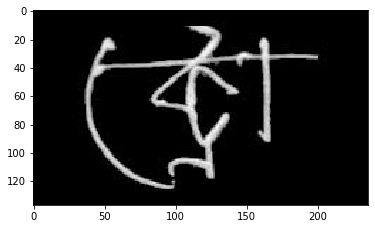

In [12]:
img = cv2.imread(preprocessed_train_df['preprocessed_image_path'][0])
plt.imshow(img, cmap='gray')
plt.show()

In [13]:
preprocessed_train_df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path
0,Train_0,15,9,5,ক্ট্রো,../data/bengali_centered/dataset_1/Train_0.jpg
1,Train_1,159,0,0,হ,../data/bengali_centered/dataset_1/Train_1.jpg
2,Train_2,22,3,5,খ্রী,../data/bengali_centered/dataset_1/Train_2.jpg
3,Train_3,53,2,2,র্টি,../data/bengali_centered/dataset_1/Train_3.jpg
4,Train_4,71,9,5,থ্রো,../data/bengali_centered/dataset_1/Train_4.jpg
...,...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...
200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...
200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...
200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...


In [14]:
ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [15]:
# from sklearn.model_selection import train_test_split

In [16]:
def get_len_train_test_split(full_len: int, test_ratio: float) -> tuple:
    test_len = int(full_len * test_ratio)
    train_len = full_len - test_len
    return train_len, test_len

In [17]:
def get_len_dataset(dataset) -> int:
    count = 0
    for data in dataset:
        count += 1
    
    return count

In [18]:
path_list = preprocessed_train_df['preprocessed_image_path']

root_list = preprocessed_train_df['grapheme_root']
consonant_list = preprocessed_train_df['consonant_diacritic']
vowel_list = preprocessed_train_df['vowel_diacritic']

batch_size = 256
epochs = 10

In [19]:
len_train, len_test_full = get_len_train_test_split(full_len=len(path_list), test_ratio=0.3)
len_val, len_test = get_len_train_test_split(full_len=len_test_full, test_ratio=0.7)

print(f"Train size : {len_train}, Val size : {len_val}, Test size : {len_test}")

Train size : 140588, Val size : 18076, Test size : 42176


In [20]:
path_list

0            ../data/bengali_centered/dataset_1/Train_0.jpg
1            ../data/bengali_centered/dataset_1/Train_1.jpg
2            ../data/bengali_centered/dataset_1/Train_2.jpg
3            ../data/bengali_centered/dataset_1/Train_3.jpg
4            ../data/bengali_centered/dataset_1/Train_4.jpg
                                ...                        
200835    ../data/bengali_centered/dataset_4/Train_20083...
200836    ../data/bengali_centered/dataset_4/Train_20083...
200837    ../data/bengali_centered/dataset_4/Train_20083...
200838    ../data/bengali_centered/dataset_4/Train_20083...
200839    ../data/bengali_centered/dataset_4/Train_20083...
Name: preprocessed_image_path, Length: 200840, dtype: object

In [21]:
# dataset = tf.data.Dataset.from_tensor_slices({
#     "path_list": path_list,
#     "root_list": root_list,
#     "consonant_list": consonant_list,
#     "vowel_list": vowel_list
# })
dataset = tf.data.Dataset.from_tensor_slices((path_list, root_list, consonant_list, vowel_list))

In [22]:
dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.int32, tf.int32, tf.int32)>

In [23]:
train_dataset = dataset.take(len_train)
test_dataset = dataset.skip(len_train)
val_dataset = test_dataset.take(len_val)
test_dataset = test_dataset.skip(len_val)

#print(f"Train size : {get_len_dataset(train_dataset)}, Val size : {get_len_dataset(val_dataset)}, Test size : {get_len_dataset(test_dataset)}")
# Train size : 140588, Val size : 18076, Test size : 42176

In [ ]:
history.epoch

In [ ]:
history

In [ ]:
model.

In [ ]:
a

In [ ]:
a = [1]

In [265]:
for epoch in range(epochs):
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(batch_size).take(1):
        print(path, root, consonant, vowel)
    
    print(f"Epoch {epoch} - ")

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

In [126]:
# x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
#     train_test_split(path_list, root_one_hot_list, consonant_one_hot_list, vowel_one_hot_list, test_size=0.3)

In [127]:
x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
    train_test_split(path_list, root_list, consonant_list, vowel_list, test_size=0.3)

In [128]:
x_train_path

87499     ../data/bengali_centered/dataset_2/Train_87499...
75515     ../data/bengali_centered/dataset_2/Train_75515...
95056     ../data/bengali_centered/dataset_2/Train_95056...
100572    ../data/bengali_centered/dataset_3/Train_10057...
144608    ../data/bengali_centered/dataset_3/Train_14460...
                                ...                        
49302     ../data/bengali_centered/dataset_1/Train_49302...
37481     ../data/bengali_centered/dataset_1/Train_37481...
141396    ../data/bengali_centered/dataset_3/Train_14139...
43364     ../data/bengali_centered/dataset_1/Train_43364...
182671    ../data/bengali_centered/dataset_4/Train_18267...
Name: preprocessed_image_path, Length: 140588, dtype: object

In [ ]:
tf.data.Dataset.from_tensor_slices

In [22]:
size = 5000

In [23]:
tmp_x_trains = list()
img = None

time_st = time.time()
for i in range(size):
    img = tf.io.read_file(x_train_path[i])
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    tmp_x_trains.append(img)
time_ed = time.time()
print(f"Elapsed TIme : {time_ed - time_st}")

Elapsed TIme : 36.66111707687378


In [24]:
y_train_root = tf.convert_to_tensor(y_train_root)
y_test_root = tf.convert_to_tensor(y_test_root)
y_train_consonant = tf.convert_to_tensor(y_train_consonant)
y_test_consonant = tf.convert_to_tensor(y_test_consonant)
y_train_vowl = tf.convert_to_tensor(y_train_vowl)
y_test_vowel = tf.convert_to_tensor(y_test_vowel)

In [25]:
tmp_x_trains = tf.convert_to_tensor(tmp_x_trains)

In [26]:
print(len(tmp_x_trains), len(y_train_consonant))

5000 140588
